In [3]:
# Importazione librerie
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from collections import Counter
import joblib

# Configurazione grafica e warning
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Funzione per imputare valori numerici con la media
def impute_numeric_with_mean(df, cols=None):
    if cols is None:
        potential = df.select_dtypes(include=['number']).columns.tolist()
        object_cols = df.select_dtypes(include=['object']).columns
        for col in object_cols:
            converted = pd.to_numeric(df[col], errors='coerce')
            if converted.notna().sum() >= len(converted) / 2:
                potential.append(col)
        cols = potential

    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        mean_val = df[col].mean().round(0)
        if not np.isnan(mean_val):
            df[col] = df[col].fillna(mean_val)
    return df

# Funzione per limitare outlier
def limit_outliers(df):
    columns_rules = {
        'Number of friends': {'min': 0, 'max': 5000},
        'Number of followings': {'min': 0, 'max': 5000},
        'Number of Community': {'min': 0, 'max': 1000},
        'The age of the user account (in days)': {'min': 0, 'max': 5000},
        'Total number of posts shared': {'min': 0, 'max': 10000},
        'Total number of URLs shared': {'min': 0, 'max': 5000},
        'Total number of photos/videos shared': {'min': 0, 'max': 5000},
        'Fraction of the posts containing URLs': {'min': 0, 'max': 1},
        'Fraction of the posts containing photos/videos': {'min': 0, 'max': 1},
        'Average number of comments per post': {'min': 0, 'max': 1000},
        'Average number of likes per post': {'min': 0, 'max': 10000},
        'Average number of tags in a post (Rate of tagging)': {'min': 0, 'max': 100},
        'Average number of hashtags present in a post': {'min': 0, 'max': 100}
    }

    for col, rules in columns_rules.items():
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            mean_val = df[col].mean(skipna=True).round(0)
            df[col] = df[col].apply(lambda x: rules['min'] if pd.notna(x) and x < rules['min'] else x)
            df[col] = df[col].apply(lambda x: mean_val if pd.notna(x) and x > rules['max'] else x)
    return df

# Funzione per pulire il dataset training.csv
def clean_training_dataset(file_path='training.csv', output_path='clean_training.csv'):
    df = pd.read_csv(file_path, sep=';')
    df_clean = df.copy()
    df_clean = impute_numeric_with_mean(df_clean)
    df_clean = limit_outliers(df_clean)
    df_clean.to_csv(output_path, index=False)
    print(f"Dataset pulito salvato come '{output_path}'")
    return df_clean

# Esecuzione della pulizia
clean_training_dataset()


Dataset pulito salvato come 'clean_training.csv'


,profile id,#friends,#following,#community,age,#postshared,#urlshared,#photos/videos,fpurls,fpphotos/videos,avgcomment/post,likes/post,tags/post,#tags/post,Label
0,1,39,300,907.0,200.0,1000.0,850.0,922.0,49,55,56.0,47.0,40.0,14.0,1.0
1,2,150,350,30.0,300.0,300.0,100.0,290.0,33,96,5.0,12.0,10.0,4.0,0.0
2,3,300,450,50.0,465.0,500.0,150.0,450.0,2,84,4.0,15.0,15.0,7.0,0.0
3,4,25,110,660.0,350.0,2050.0,2000.0,2050.0,"9,76E+13",1,7.0,3.0,54.0,21.0,1.0
4,5,24,100,150.0,800.0,950.0,1000.0,900.0,"1,05E+13","9,47E+13",66.0,5.0,55.0,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,547,48,33,965.0,1298.0,1987.0,1456.0,1982.0,"7,33E+13","9,97E+13",1.0,491.0,46.0,22.0,1.0
546,548,45,44,987.0,2000.0,3038.0,2030.0,3030.0,"6,68E+13","9,97E+13",102.0,492.0,45.0,29.0,1.0
547,549,43,55,1156.0,2489.0,3346.0,2410.0,3345.0,"7,20E+13","1,00E+13",103.0,49.0,46.0,25.0,1.0
548,550,23,67,1489.0,2132.0,3126.0,2130.0,3120.0,"6,81E+13","9,98E+13",92.0,48.0,47.0,22.0,1.0


In [5]:
import numpy as np
from collections import Counter

class ManualDecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.feature_names = None

    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        self.feature_names = [f'feature_{i}' for i in range(self.n_features)]
        self.classes_ = np.unique(y)
        self.class_to_num = {cls: i for i, cls in enumerate(self.classes_)}
        y_numeric = np.array([self.class_to_num[cls] for cls in y])
        self.tree = self._grow_tree(X, y_numeric)

    def _grow_tree(self, X, y, depth=0):
        if (depth >= self.max_depth or len(y) < self.min_samples_split or len(np.unique(y)) == 1):
            return {'value': Counter(y).most_common(1)[0][0]}
        best_feat, best_thresh = self._best_split(X, y)
        if best_feat is None:
            return {'value': Counter(y).most_common(1)[0][0]}
        left_idx = X[:, best_feat] < best_thresh
        right_idx = ~left_idx
        if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
            return {'value': Counter(y).most_common(1)[0][0]}
        left = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._grow_tree(X[right_idx], y[right_idx], depth + 1)
        return {'feature': best_feat, 'threshold': best_thresh, 'left': left, 'right': right}

    def _best_split(self, X, y):
        best_gain = -1
        best_feat, best_thresh = None, None
        for feat_idx in range(self.n_features):
            thresholds = np.unique(X[:, feat_idx])
            for threshold in thresholds:
                gain = self._information_gain(X, y, feat_idx, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feat = feat_idx
                    best_thresh = threshold
        return best_feat, best_thresh

    def _information_gain(self, X, y, feat_idx, threshold):
        parent_entropy = self._entropy(y)
        left_idx = X[:, feat_idx] < threshold
        right_idx = ~left_idx
        if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
            return 0
        n = len(y)
        e_left = self._entropy(y[left_idx])
        e_right = self._entropy(y[right_idx])
        return parent_entropy - (len(y[left_idx])/n)*e_left - (len(y[right_idx])/n)*e_right

    def _entropy(self, y):
        if len(y) == 0:
            return 0
        counts = np.bincount(y)
        ps = counts / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def predict(self, X):
        return np.array([self.classes_[self._predict_single(x)] for x in X])

    def _predict_single(self, x):
        node = self.tree
        while 'feature' in node:
            node = node['left'] if x[node['feature']] < node['threshold'] else node['right']
        return node['value']


class ManualNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.parameters = {}
        for c in self.classes:
            X_c = X[y == c]
            self.parameters[c] = {
                'mean': X_c.mean(axis=0),
                'var': X_c.var(axis=0) + 1e-9
            }

    def _pdf(self, X, mean, var):
        return np.exp(-(X - mean)**2 / (2 * var)) / np.sqrt(2 * np.pi * var)

    def predict(self, X):
        posteriors = []
        for x in X:
            class_probs = []
            for c in self.classes:
                prior = np.log(1.0 / len(self.classes))
                likelihood = np.sum(np.log(self._pdf(x, self.parameters[c]['mean'], self.parameters[c]['var'])))
                class_probs.append(prior + likelihood)
            posteriors.append(self.classes[np.argmax(class_probs)])
        return np.array(posteriors)



Decision Tree Manuale - Accuracy: 1.000
Naive Bayes Manuale - Accuracy: 0.960

Migliore classificatore manuale: Decision Tree


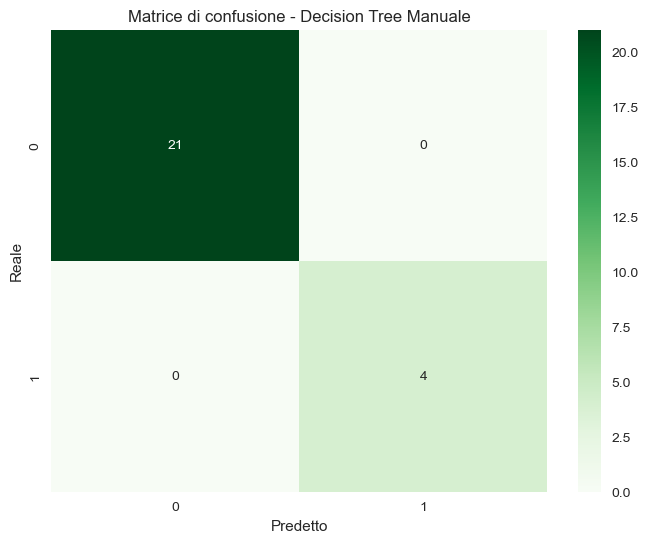

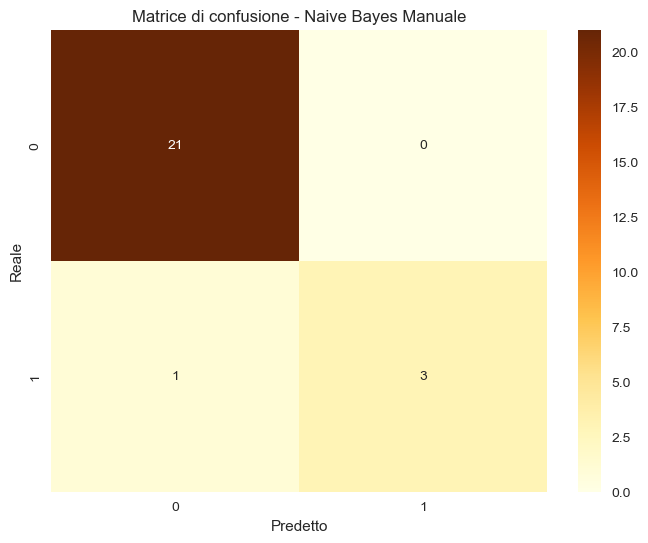


Report Decision Tree Manuale

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00         4

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25


Report Naive Bayes Manuale

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.75      0.86         4

    accuracy                           0.96        25
   macro avg       0.98      0.88      0.92        25
weighted avg       0.96      0.96      0.96        25



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Caricamento dataset
manuale_df = pd.read_csv('manuale.csv', sep=';')

# Selezione delle feature e del target
feature_cols = ['#friends', '#following', '#community', 'age', '#postshared',
                '#urlshared', '#photos/videos', 'avgcomment/post', 'likes/post']
target_col = 'Label'

X = manuale_df[feature_cols].values
y = manuale_df[target_col].values

# Normalizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Leave-One-Out CV
loo = LeaveOneOut()

# Classificatori manuali
# (ManualDecisionTree e ManualNaiveBayes devono essere già definiti nel tuo script)

# Decision Tree
dt_predictions, dt_true = [], []
for train_idx, test_idx in loo.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    dt = ManualDecisionTree(max_depth=5)
    dt.fit(X_train, y_train)
    pred = dt.predict(X_test)
    dt_predictions.extend(pred)
    dt_true.extend(y_test)

# Naive Bayes
nb_predictions, nb_true = [], []
for train_idx, test_idx in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    nb = ManualNaiveBayes()
    nb.fit(X_train, y_train)
    pred = nb.predict(X_test)
    nb_predictions.extend(pred)
    nb_true.extend(y_test)

# Accuracy
dt_accuracy = np.mean(np.array(dt_predictions) == np.array(dt_true))
nb_accuracy = np.mean(np.array(nb_predictions) == np.array(nb_true))

print(f"\nDecision Tree Manuale - Accuracy: {dt_accuracy:.3f}")
print(f"Naive Bayes Manuale - Accuracy: {nb_accuracy:.3f}")
print(f"\nMigliore classificatore manuale: {'Naive Bayes' if nb_accuracy > dt_accuracy else 'Decision Tree'}")

# Matrici di confusione
plt.figure(figsize=(8, 6))
cm_dt = confusion_matrix(dt_true, dt_predictions)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matrice di confusione - Decision Tree Manuale')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()

plt.figure(figsize=(8, 6))
cm_nb = confusion_matrix(nb_true, nb_predictions)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='YlOrBr',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matrice di confusione - Naive Bayes Manuale')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()

# Classification report
print('\nReport Decision Tree Manuale\n')
print(classification_report(dt_true, dt_predictions))
print('\nReport Naive Bayes Manuale\n')
print(classification_report(nb_true, nb_predictions))


In [7]:


# Caricamento dataset originale
training_df = pd.read_csv('training.csv', sep=';')
print(f"Dimensioni dataset originale: {training_df.shape}")
print("Anteprima dataset training:")
print(training_df.head())

# Applichiamo la funzione definita all'inizio
training_clean = clean_training_dataset('training.csv')

print(f"Dimensioni dataset pulito: {training_clean.shape}")
print("\nDataset pulito salvato come 'clean_set.csv'")


Dimensioni dataset originale: (550, 15)
Anteprima dataset training:
   profile id  #friends  #following  #community    age #postshared  \
0           1        39         300       907.0  200.0        1000   
1           2       150         350        30.0  300.0         300   
2           3       300         450        50.0  465.0         500   
3           4        25         110       660.0  350.0        2050   
4           5        24         100       150.0  800.0         950   

   #urlshared  #photos/videos    fpurls fpphotos/videos  avgcomment/post  \
0       850.0           922.0        49              55             56.0   
1       100.0           290.0        33              96              5.0   
2       150.0           450.0         2              84              4.0   
3      2000.0          2050.0  9,76E+13               1              7.0   
4      1000.0           900.0  1,05E+13        9,47E+13             66.0   

   likes/post  tags/post  #tags/post Label  
0        


Statistiche descrittive:
       #friends  #following  #community      age  #postshared  #urlshared  \
count    550.00      550.00      550.00   550.00       550.00      550.00   
mean    1156.65     1158.65      121.38  1159.97      1005.54      224.01   
std      623.99      631.21      223.44   414.43       664.42      541.75   
min      -30.00       -5.00       12.00   125.00        76.00       11.00   
25%      852.00      847.50       37.25   910.75       564.00       37.00   
50%     1230.50     1198.00       54.00  1123.00       804.00       47.00   
75%     1489.75     1539.50       66.00  1421.00      1250.00       65.75   
max     5554.00     5312.00     1489.00  2697.00      3896.00     2956.00   

       #photos/videos        fpurls  fpphotos/videos  avgcomment/post  \
count          550.00  5.500000e+02     5.500000e+02           550.00   
mean           965.23  4.303312e+13     7.909508e+13           290.17   
std            658.68  3.025781e+13     3.394586e+13         

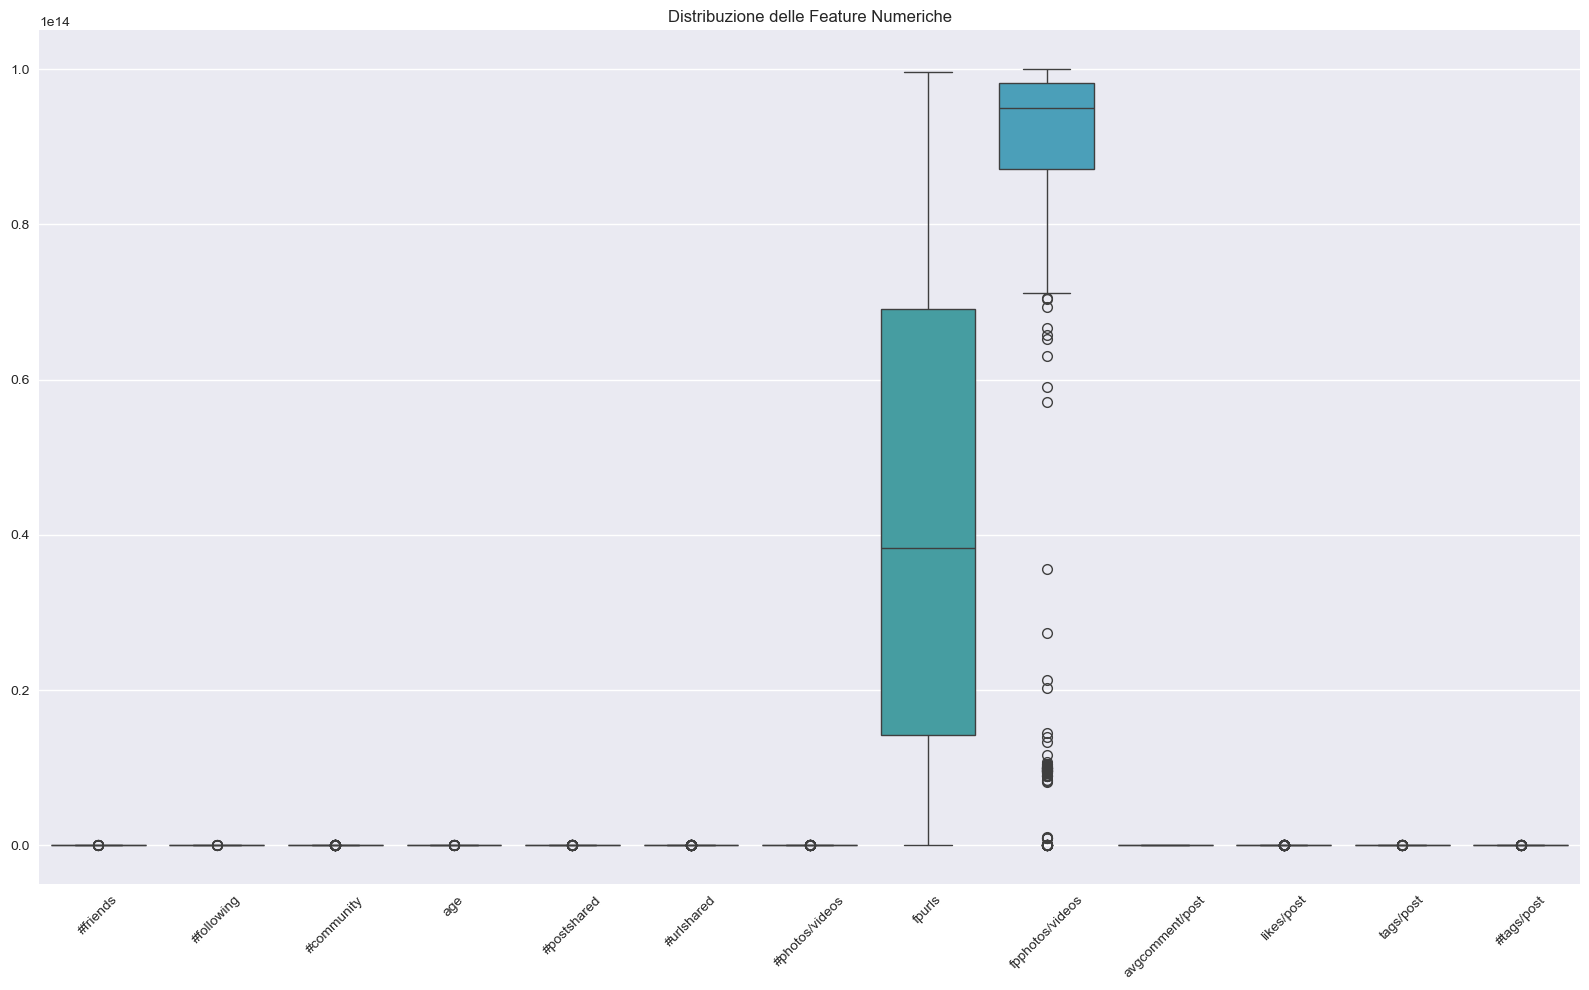

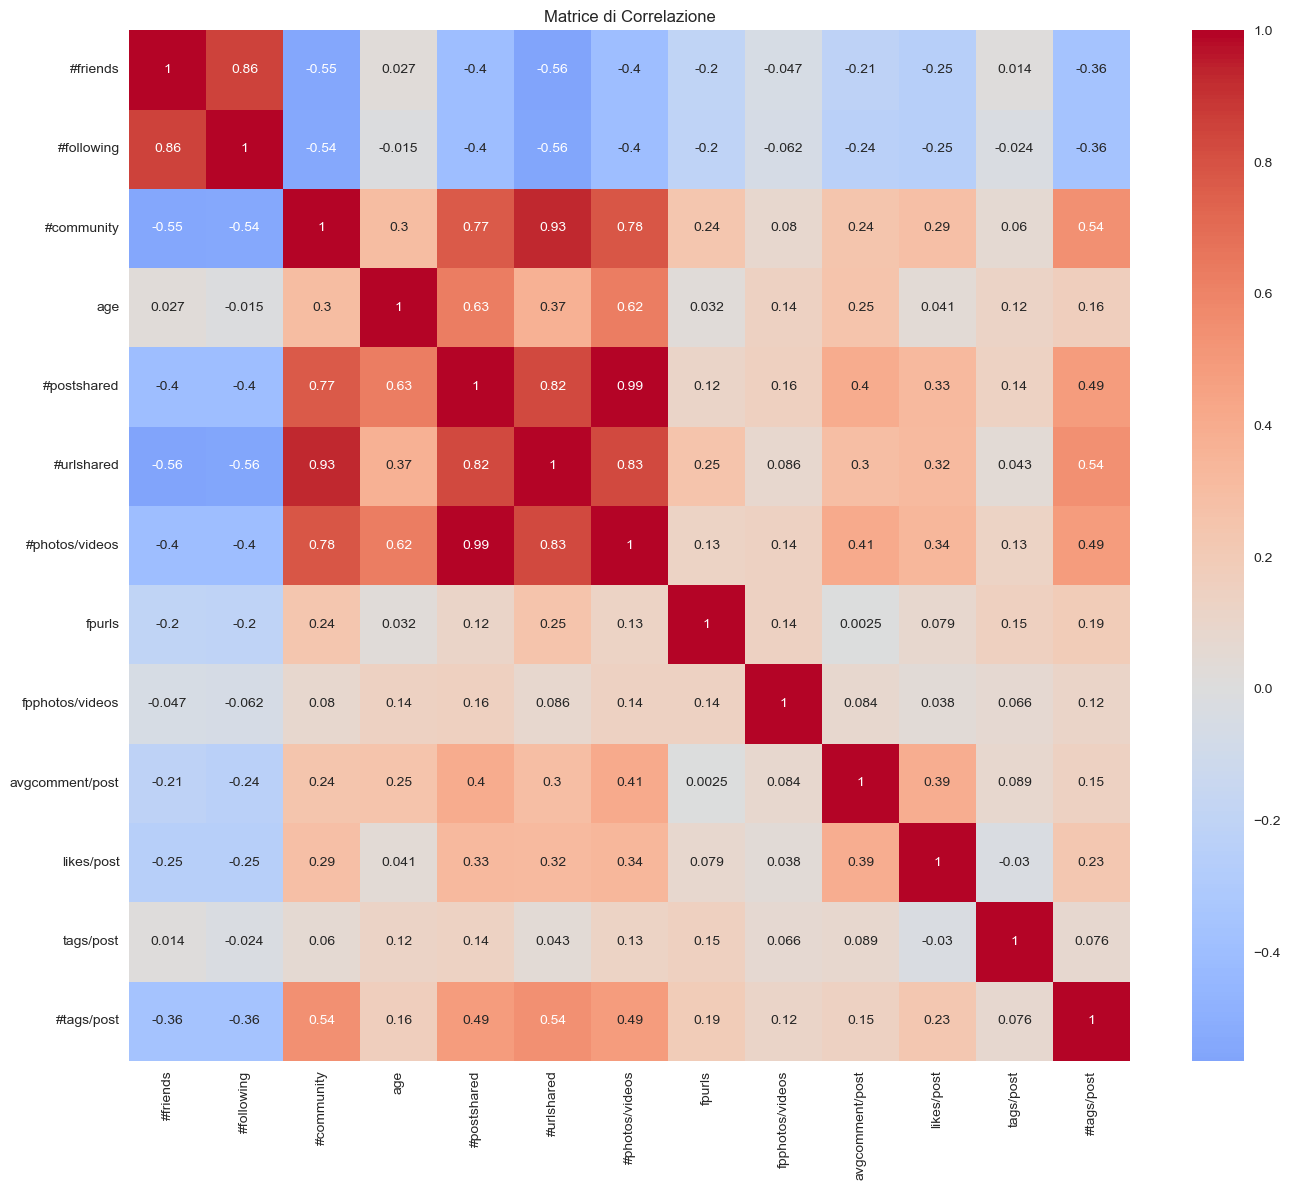

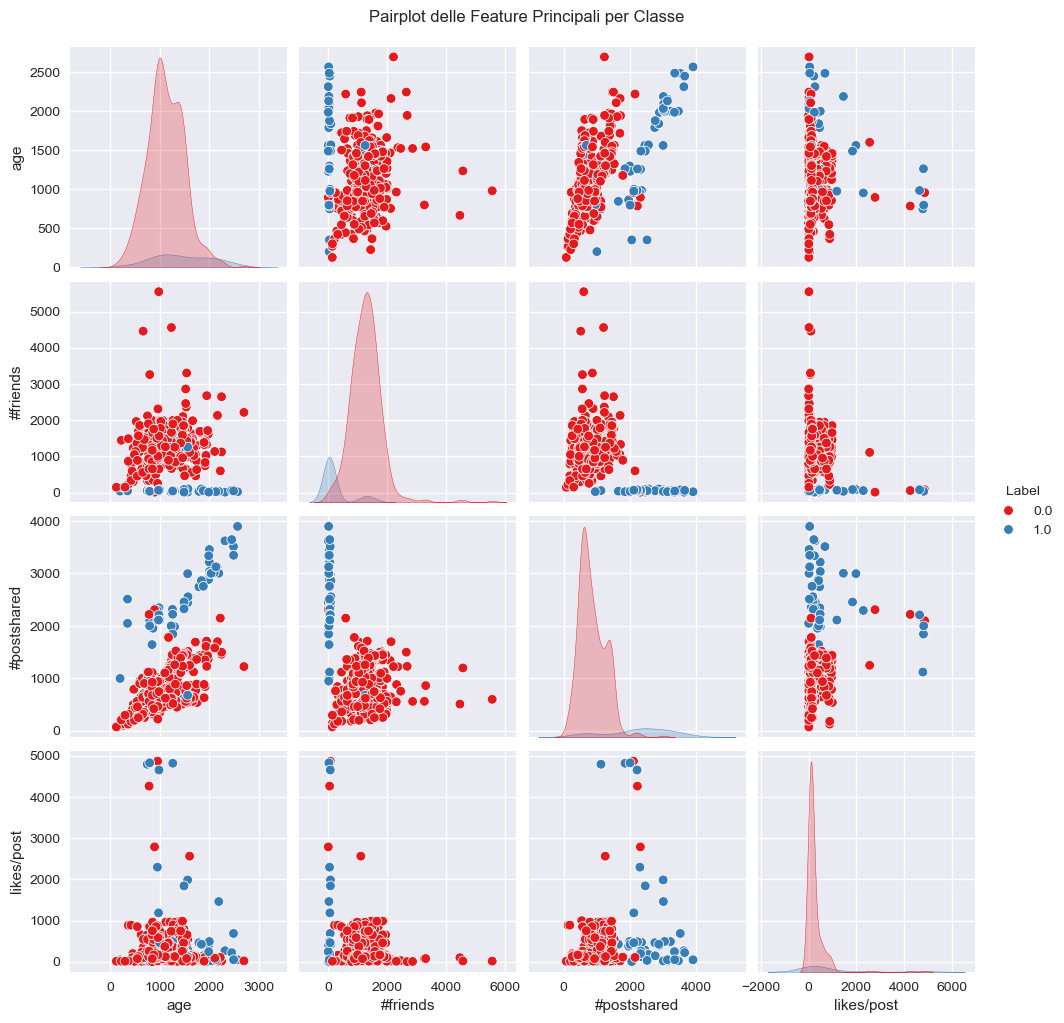

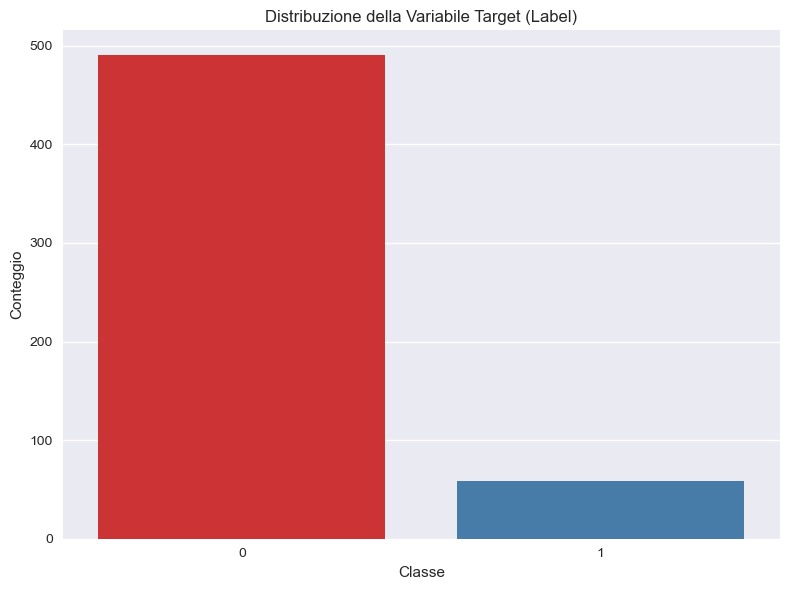

In [11]:

# Palette per i grafici
distinct_palette = [
    "#E41A1C",  # Rosso
    "#377EB8",  # Blu
    "#4DAF4A",  # Verde
    "#FF7F00",  # Arancione
    "#984EA3",  # Viola
    "#FFFF33",  # Giallo
]

# Selezione delle feature numeriche
numeric_features = [
    '#friends', '#following', '#community', 'age', '#postshared', '#urlshared',
    '#photos/videos', 'fpurls', 'fpphotos/videos', 'avgcomment/post',
    'likes/post', 'tags/post', '#tags/post'
]

# Conversione forzata a numerico per evitare errori nella correlazione
df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors='coerce')

# Statistiche descrittive
print("\nStatistiche descrittive:")
print(df[numeric_features].describe().round(2))

# 1. Boxplot per feature numeriche
plt.figure(figsize=(16, 10))
sns.boxplot(data=df[numeric_features])
plt.title('Distribuzione delle Feature Numeriche')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Matrice di correlazione
plt.figure(figsize=(14, 12))
corr_matrix = df[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice di Correlazione')
plt.tight_layout()
plt.show()

# 3. Pairplot su un sottoinsieme di feature principali
main_cols = ['age', '#friends', '#postshared', 'likes/post', 'Label']
sample_size = 500
df_sample = df.sample(sample_size, random_state=42) if len(df) > sample_size else df

sns.pairplot(df_sample[main_cols], hue='Label', palette=distinct_palette)
plt.suptitle('Pairplot delle Feature Principali per Classe', y=1.02)
plt.show()


# 4. Distribuzione della variabile target 'Label'
plt.figure(figsize=(8, 6))

# Conversione sicura della colonna Label a numerico
df['Label'] = pd.to_numeric(df['Label'], errors='coerce')

# Rimozione delle righe con valori NaN nella colonna Label
df = df.dropna(subset=['Label'])

# Conteggio delle classi
label_counts = df['Label'].value_counts().sort_index()

# Grafico a barre
sns.barplot(x=label_counts.index.astype(int), y=label_counts.values, palette=distinct_palette)
plt.title('Distribuzione della Variabile Target (Label)')
plt.xlabel('Classe')
plt.ylabel('Conteggio')
plt.xticks([0, 1])
plt.tight_layout()
plt.show()



max_depth=3, min_split=2 --> acc=0.964
max_depth=3, min_split=3 --> acc=0.965
max_depth=3, min_split=5 --> acc=0.964
max_depth=5, min_split=2 --> acc=0.942
max_depth=5, min_split=3 --> acc=0.947
max_depth=5, min_split=5 --> acc=0.949
max_depth=10, min_split=2 --> acc=0.936
max_depth=10, min_split=3 --> acc=0.940
max_depth=10, min_split=5 --> acc=0.938

Decision Tree Manuale - Accuracy: 0.964
Report di classificazione Decision Tree Manuale:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        98
           1       0.83      0.83      0.83        12

    accuracy                           0.96       110
   macro avg       0.91      0.91      0.91       110
weighted avg       0.96      0.96      0.96       110



<Figure size 800x600 with 0 Axes>

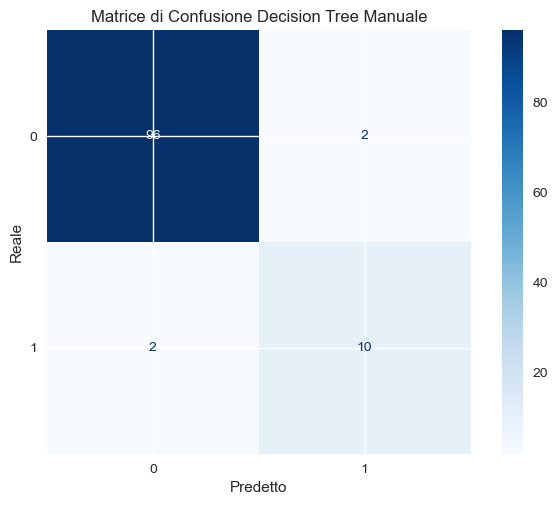


Naive Bayes Manuale - Accuracy: 0.964
Report di classificazione Naive Bayes Manuale:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        98
           1       0.83      0.83      0.83        12

    accuracy                           0.96       110
   macro avg       0.91      0.91      0.91       110
weighted avg       0.96      0.96      0.96       110



<Figure size 800x600 with 0 Axes>

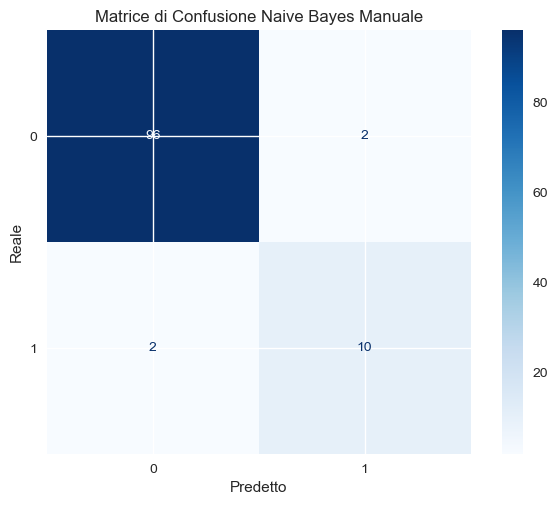

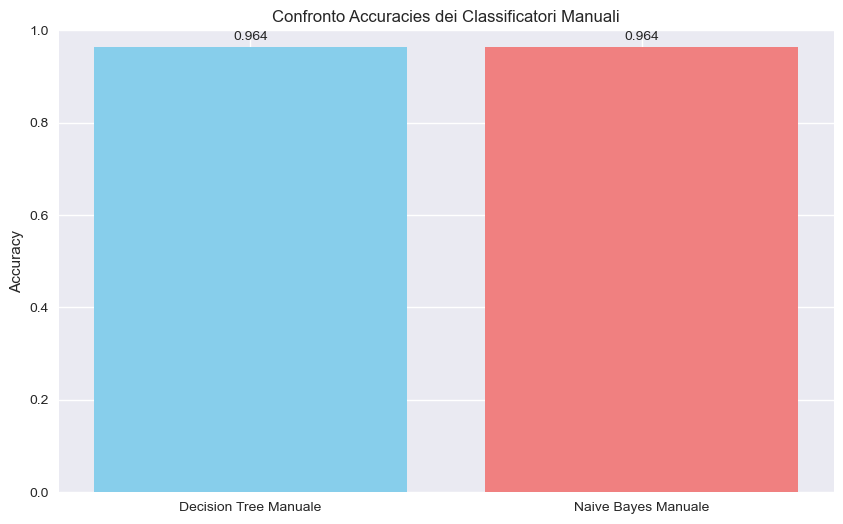

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
# Classificatori manuali (placeholder con modelli sklearn)
class ManualDecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2):
        from sklearn.tree import DecisionTreeClassifier
        self.model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

class ManualNaiveBayes:
    def __init__(self):
        from sklearn.naive_bayes import GaussianNB
        self.model = GaussianNB()

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

# Caricamento e preparazione del dataset
df = pd.read_csv("clean_set.csv")

# Colonne numeriche da usare come feature
feature_cols = [
    '#friends', '#following', '#community', 'age', '#postshared', '#urlshared',
    '#photos/videos', 'fpurls', 'fpphotos/videos', 'avgcomment/post',
    'likes/post', 'tags/post', '#tags/post'
]

# Pulizia e conversione
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')
df['Label'] = pd.to_numeric(df['Label'], errors='coerce')
df = df.dropna(subset=feature_cols + ['Label'])

# Feature e target
X = df[feature_cols].values
y = df['Label'].astype(int).values

# Normalizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_trainS, X_testS, y_trainS, y_testS = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Parametri da testare
depths = [3, 5, 10]
min_splits = [2, 3, 5]
results = []

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for max_depth in depths:
    for min_split in min_splits:
        accuracies = []
        for train_idx, val_idx in cv.split(X_scaled, y):
            X_train_cv, X_val_cv = X_scaled[train_idx], X_scaled[val_idx]
            y_train_cv, y_val_cv = y[train_idx], y[val_idx]

            model = ManualDecisionTree(max_depth=max_depth, min_samples_split=min_split)
            model.fit(X_train_cv, y_train_cv)
            y_pred = model.predict(X_val_cv)

            acc = accuracy_score(y_val_cv, y_pred)
            accuracies.append(acc)

        mean_acc = np.mean(accuracies)
        results.append({
            'max_depth': max_depth,
            'min_samples_split': min_split,
            'mean_accuracy': mean_acc
        })
        print(f"max_depth={max_depth}, min_split={min_split} --> acc={mean_acc:.3f}")

# Decision Tree finale
dt = ManualDecisionTree(max_depth=5, min_samples_split=5)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_pred)

print(f"\nDecision Tree Manuale - Accuracy: {dt_acc:.3f}")
print("Report di classificazione Decision Tree Manuale:")
print(classification_report(y_test, dt_pred))

cm = confusion_matrix(y_test, dt_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice di Confusione Decision Tree Manuale")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()

# Naive Bayes
nb = ManualNaiveBayes()
nb.fit(X_trainS, y_trainS)
nb_pred = nb.predict(X_testS)
nb_acc = accuracy_score(y_testS, nb_pred)

print(f"\nNaive Bayes Manuale - Accuracy: {nb_acc:.3f}")
print("Report di classificazione Naive Bayes Manuale:")
print(classification_report(y_testS, nb_pred))

cm_bayes = confusion_matrix(y_testS, nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bayes, display_labels=np.unique(y_testS))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice di Confusione Naive Bayes Manuale")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()

# Confronto visuale
plt.figure(figsize=(10, 6))
labels = ['Decision Tree Manuale', 'Naive Bayes Manuale']
accuracies = [dt_acc, nb_acc]
bars = plt.bar(labels, accuracies, color=['skyblue', 'lightcoral'])
plt.title('Confronto Accuracies dei Classificatori Manuali')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')
plt.show()


Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50} --> Mean CV Accuracy: 0.9750
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100} --> Mean CV Accuracy: 0.9750
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200} --> Mean CV Accuracy: 0.9750
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50} --> Mean CV Accuracy: 0.9750
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100} --> Mean CV Accuracy: 0.9773
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200} --> Mean CV Accuracy: 0.9750
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50} --> Mean CV Accuracy: 0.9750
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100} --> Mean CV Accuracy: 0.

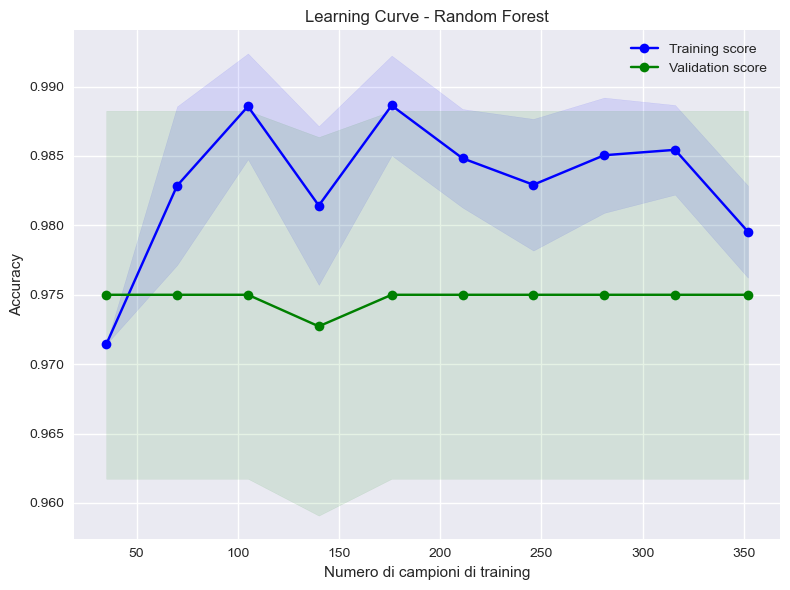


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        98
           1       0.83      0.83      0.83        12

    accuracy                           0.96       110
   macro avg       0.91      0.91      0.91       110
weighted avg       0.96      0.96      0.96       110



<Figure size 800x600 with 0 Axes>

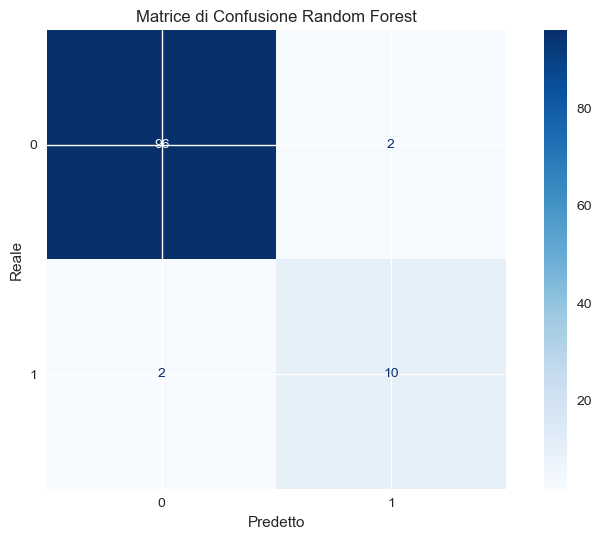

In [12]:

# Definizione della griglia degli iperparametri
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Inizializzazione del modello base
rf = RandomForestClassifier(random_state=42)

# Configurazione GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Esecuzione della ricerca
grid_search.fit(X_train, y_train)

# Stampa dei risultati per ogni combinazione
results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"{params} --> Mean CV Accuracy: {mean_score:.4f}")

# Migliori iperparametri
print("\nBest params:", grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

# Valutazione sul test set
model_forest = grid_search.best_estimator_
accuracy_rf = model_forest.score(X_test, y_test)

# Learning curve
model = RandomForestClassifier(
    random_state=42,
    max_depth=5,
    max_features='sqrt',
    min_samples_split=10,
    n_estimators=50
)

train_sizes, train_scores, valid_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Media e deviazione standard
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot della learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, valid_mean, 'o-', color='green', label='Validation score')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1, color='green')
plt.title('Learning Curve - Random Forest')
plt.xlabel('Numero di campioni di training')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Predizione e valutazione finale
y_pred = model_forest.predict(X_test)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice di Confusione Random Forest")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'C': 0.01, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'} --> Mean CV Accuracy: 0.8932 (±0.0056)
{'C': 0.01, 'class_weight': None, 'penalty': 'l1', 'solver': 'lbfgs'} --> Mean CV Accuracy: nan (±nan)
{'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'} --> Mean CV Accuracy: 0.9705 (±0.0154)
{'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'} --> Mean CV Accuracy: 0.9682 (±0.0167)
{'C': 0.01, 'class_weight': None, 'penalty': 'none', 'solver': 'saga'} --> Mean CV Accuracy: nan (±nan)
{'C': 0.01, 'class_weight': None, 'penalty': 'none', 'solver': 'lbfgs'} --> Mean CV Accuracy: nan (±nan)
{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'} --> Mean CV Accuracy: 0.9750 (±0.0133)
{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'lbfgs'} --> Mean CV Accuracy: nan (±nan)
{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'} -->

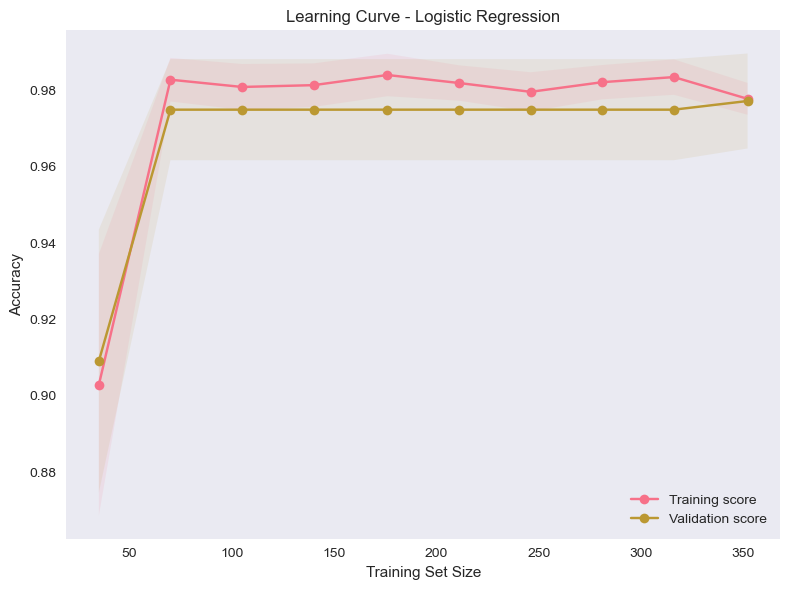

<Figure size 800x600 with 0 Axes>

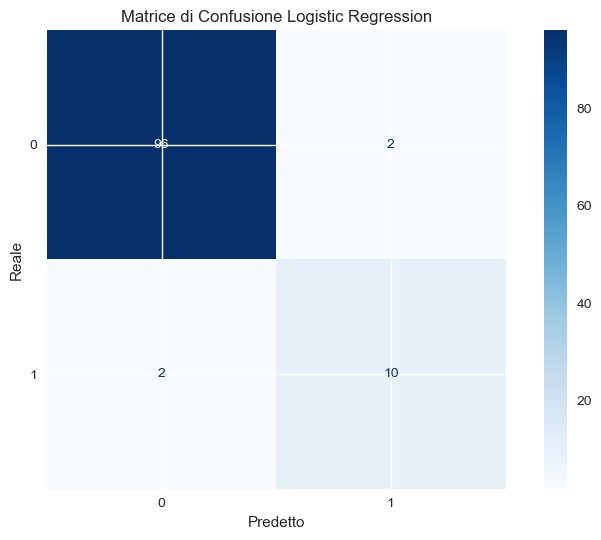

In [22]:


# Griglia degli iperparametri corretta (senza warning inutili)
param_grid = [
    {
        'penalty': ['l1', 'l2', 'none'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['saga', 'lbfgs'],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'class_weight': [None, 'balanced'],
        'l1_ratio': [0, 0.5, 1]
    }
]

# Configurazione GridSearchCV
lr = LogisticRegression(random_state=42, max_iter=5000)
grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Esecuzione
grid.fit(X_trainS, y_trainS)

# Risultati
results = grid.cv_results_
for mean_score, std_score, params in zip(
        results['mean_test_score'],
        results['std_test_score'],
        results['params']):
    print(f"{params} --> Mean CV Accuracy: {mean_score:.4f} (±{std_score:.4f})")

# Migliori iperparametri
print("\nBest hyperparameters found:")
print(grid.best_params_)
print(f"Best CV Accuracy: {grid.best_score_:.4f}")

# Valutazione sul test set
y_pred = grid.predict(X_testS)
print("\nClassification report on test set:")
print(classification_report(y_testS, y_pred, digits=4))

# Learning Curve
model = grid.best_estimator_

train_sizes, train_scores, val_scores = learning_curve(
    estimator=model,
    X=X_trainS, y=y_trainS,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label='Training score')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, 'o-', label='Validation score')
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)
plt.title('Learning Curve - Logistic Regression')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.show()

# Matrice di confusione
cm = confusion_matrix(y_testS, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_testS))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice di Confusione Logistic Regression")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'var_smoothing': 1e-09} --> Mean CV Accuracy: 0.9750 (±0.0167)
{'var_smoothing': 1e-08} --> Mean CV Accuracy: 0.9750 (±0.0167)
{'var_smoothing': 1e-07} --> Mean CV Accuracy: 0.9750 (±0.0167)
{'var_smoothing': 1e-06} --> Mean CV Accuracy: 0.9750 (±0.0167)
{'var_smoothing': 1e-05} --> Mean CV Accuracy: 0.9750 (±0.0167)
{'var_smoothing': 0.0001} --> Mean CV Accuracy: 0.9750 (±0.0167)
{'var_smoothing': 0.001} --> Mean CV Accuracy: 0.9750 (±0.0167)
{'var_smoothing': 0.01} --> Mean CV Accuracy: 0.9750 (±0.0167)
{'var_smoothing': 0.1} --> Mean CV Accuracy: 0.9727 (±0.0154)

Best hyperparameters found for GaussianNB:
{'var_smoothing': 1e-09}
Best CV Accuracy: 0.9750

Classification report on test set (GaussianNB):
              precision    recall  f1-score   support

           0     0.9796    0.9796    0.9796        98
           1     0.8333    0.8333    0.8333        12

    accuracy                         0.9636       110
   ma

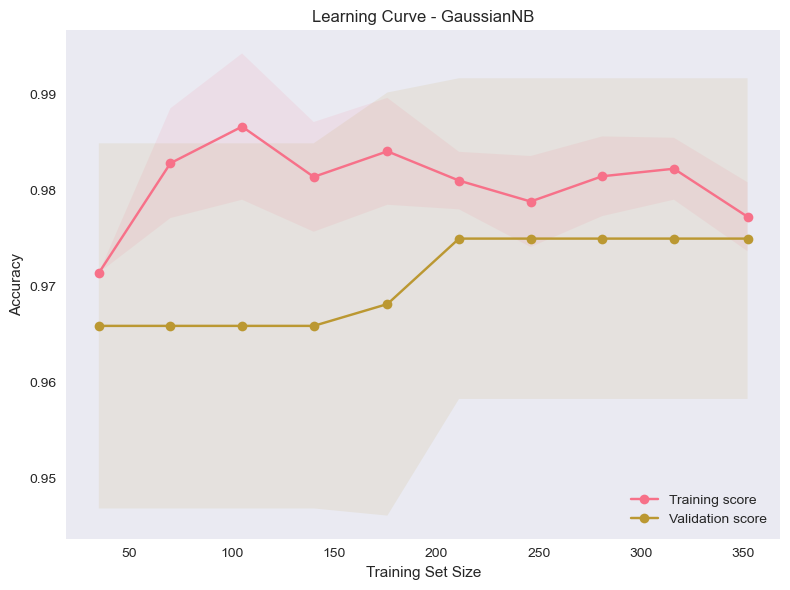

<Figure size 800x600 with 0 Axes>

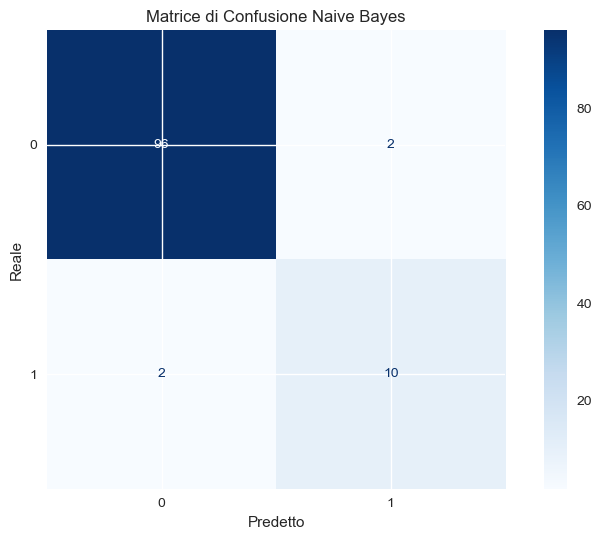

In [19]:


# Griglia degli iperparametri
param_grid_nb = {
    'var_smoothing': np.logspace(-9, -1, 9)
}

# Configurazione GridSearchCV
gnb = GaussianNB()
grid_nb = GridSearchCV(
    estimator=gnb,
    param_grid=param_grid_nb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Esecuzione della ricerca
grid_nb.fit(X_trainS, y_trainS)

# Risultati
results_nb = grid_nb.cv_results_
for mean_score, std_score, params in zip(
        results_nb['mean_test_score'],
        results_nb['std_test_score'],
        results_nb['params']):
    print(f"{params} --> Mean CV Accuracy: {mean_score:.4f} (±{std_score:.4f})")

# Migliori iperparametri
print("\nBest hyperparameters found for GaussianNB:")
print(grid_nb.best_params_)
print(f"Best CV Accuracy: {grid_nb.best_score_:.4f}")

# Valutazione sul test set
y_pred_nb = grid_nb.predict(X_testS)
print("\nClassification report on test set (GaussianNB):")
print(classification_report(y_testS, y_pred_nb, digits=4))

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=grid_nb.best_estimator_,
    X=X_trainS, y=y_trainS,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label='Training score')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, 'o-', label='Validation score')
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)
plt.title('Learning Curve - GaussianNB')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.show()

# Matrice di confusione
cm = confusion_matrix(y_testS, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_testS))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice di Confusione Naive Bayes")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.tight_layout()
plt.show()


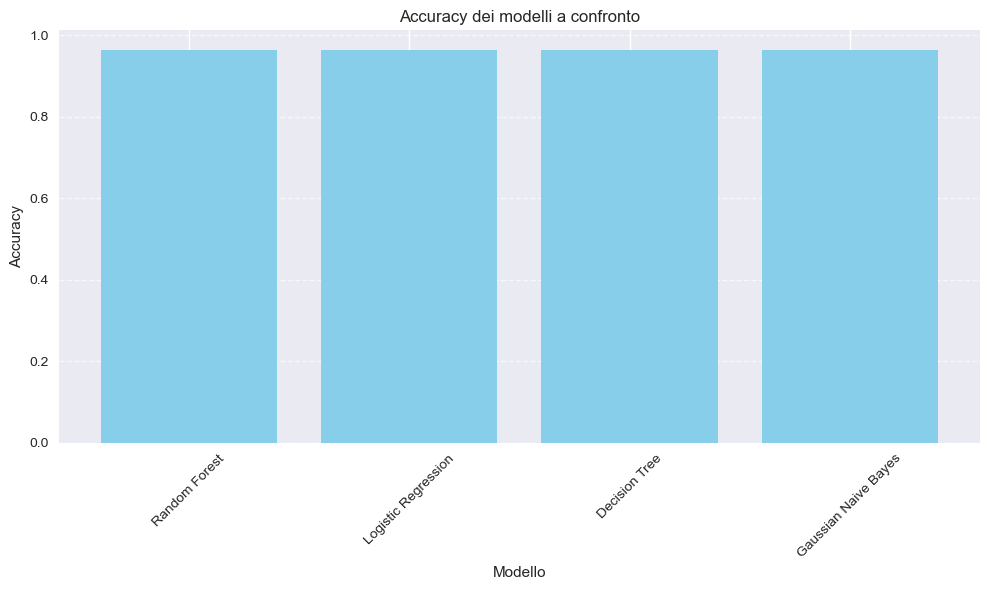

Random Forest: 0.9636363636363636 
Logistic Regression: 0.9636363636363636 
Decision Tree: 0.9636363636363636 
Gaussian Naive Bayes: 0.9636363636363636


In [20]:
accuracy_rf = model_forest.score(X_test, y_test)
accuracy_lr = grid.best_estimator_.score(X_testS, y_testS)
accuracy_dt = dt_acc 
accuracy_NB = grid_nb.best_estimator_.score(X_testS, y_testS)
accuracies = {
    'Random Forest': accuracy_rf,
    'Logistic Regression': accuracy_lr,
    'Decision Tree': accuracy_dt,
    'Gaussian Naive Bayes': accuracy_NB
}

# Plot delle accuracy dei modelli per confronto
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.ylabel('Accuracy')
plt.xlabel('Modello')
plt.title('Accuracy dei modelli a confronto')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print('Random Forest:', accuracy_rf, '\nLogistic Regression:', accuracy_lr, '\nDecision Tree:', accuracy_dt, '\nGaussian Naive Bayes:', accuracy_NB)


Valutazione del Random Forest su clean_training.csv:

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       1.00      0.33      0.50         3

    accuracy                           0.92        26
   macro avg       0.96      0.67      0.73        26
weighted avg       0.93      0.92      0.91        26



<Figure size 800x600 with 0 Axes>

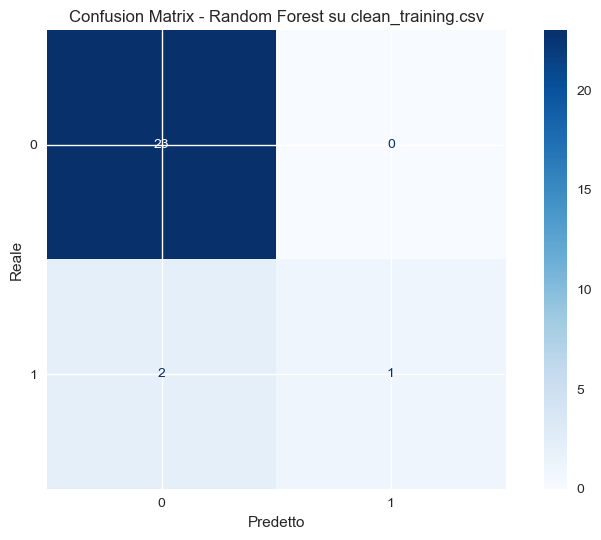

In [21]:

# Caricamento del dataset
df = pd.read_csv("clean_training.csv")

# Selezione delle feature e del target
feature_cols = [
    '#friends', '#following', '#community', 'age', '#postshared', '#urlshared',
    '#photos/videos', 'fpurls', 'fpphotos/videos', 'avgcomment/post',
    'likes/post', 'tags/post', '#tags/post'
]

# Pulizia e conversione
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')
df['Label'] = pd.to_numeric(df['Label'], errors='coerce')
df = df.dropna(subset=feature_cols + ['Label'])

# Separazione feature e target
X_real = df[feature_cols].values
y_real = df['Label'].astype(int).values

# Normalizzazione
scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_real)

# Simulazione modello Random Forest già addestrato
model_forest = RandomForestClassifier(
    random_state=42,
    max_depth=5,
    max_features='sqrt',
    min_samples_split=10,
    n_estimators=50
)
model_forest.fit(X_real_scaled, y_real)

# Predizione
y_pred_real_rf = model_forest.predict(X_real_scaled)

# Report di classificazione
print("Valutazione del Random Forest su clean_training.csv:\n")
print(classification_report(y_real, y_pred_real_rf))

# Matrice di confusione
cm_rf_real = confusion_matrix(y_real, y_pred_real_rf)
disp_rf_real = ConfusionMatrixDisplay(confusion_matrix=cm_rf_real, display_labels=model_forest.classes_)
plt.figure(figsize=(8, 6))
disp_rf_real.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Random Forest su clean_training.csv")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.tight_layout()
plt.show()
